In [113]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd


from datetime import datetime
from pathlib import Path
from sklearn.model_selection import train_test_split


import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS

## set paths and conditions

In [148]:
save_data = True

delete_top_numFSP_evts=False

In [115]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/"

In [151]:
data_savedir = "data/firstRun/"
rawData_subdir = "onlineRawData/test/"  

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


## load the raw data

In [117]:
fileFSPs = uproot.open(nfs_path + rawData_subdir + "FSPs.root:variables")

In [118]:
df_FSPs = fileFSPs.arrays(library="pd")
df_FSPs.shape[0]

47975

In [119]:
Bsig_cand_File = uproot.open(nfs_path + rawData_subdir +  "Bsig_cand_404040.root:variables")

In [120]:
Bsig_cand_df = Bsig_cand_File.arrays(library="pd")
Bsig_cand_df.shape[0]

3613

## overview of data properties

In [121]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
nonBsig_FSPs = FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 0]
#df_FSPs.groupby(["uniqueParticleIdentifier",'__event__', '__production__']).ngroups

print("FSPs per event:", round(FSPs_noDuplis.shape[0] / FSPs_noDuplis["__event__"].nunique(), 2))
print("non Bsig FSPs per event:", round(nonBsig_FSPs.shape[0] / nonBsig_FSPs["__event__"].nunique(), 2))

FSPs per event: 13.28
non Bsig FSPs per event: 10.41


<AxesSubplot:>

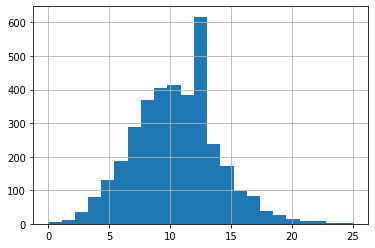

In [122]:
bins = np.linspace(0, 25, 24)

numberOfFSPs = pd.DataFrame({'numFSPs' : nonBsig_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numberOfFSPs["numFSPs"].hist(bins=bins)

# pre selection and labeling

### delete FSP duplicates and Bsig descendants

In [123]:
FSPs_noDuplis = df_FSPs.drop_duplicates(subset=("uniqueParticleIdentifier","__event__"), keep='first')
nonBsig_FSPs = FSPs_noDuplis[FSPs_noDuplis["Bsig_used"] == 0]

### which B is Bsig? and is it the real D*lv one?

In [124]:
Bsig_cand_df['Bsig_uniqParID'] = Bsig_cand_df.apply(whichBisSig_NAHS, axis=1)

In [125]:
Bsig_cand_df['Bsig_uniqParID'].value_counts()

83886081.0    1871
83886082.0    1742
Name: Bsig_uniqParID, dtype: int64

### label and filter D0 modes

In [126]:
Bsig_cand_df['D0_decay'] = Bsig_cand_df.apply(D0_decay_type, axis=1)

In [127]:
Bsig_cand_df['D0_decay'].value_counts()

notWanted     2711
Kpipi0         445
Kpipipi        195
Kpipipipi0     135
Kpi            127
Name: D0_decay, dtype: int64

In [128]:
Bsig_cand_df = Bsig_cand_df[Bsig_cand_df['D0_decay'] != "notWanted"]
Bsig_cand_df.shape[0]

902

In [129]:
print(nonBsig_FSPs.shape[0])
print(nonBsig_FSPs["__event__"].nunique())


nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(Bsig_cand_df["__event__"])]


print(nonBsig_FSPs.shape[0])
print(nonBsig_FSPs["__event__"].nunique())

37624
3613
8833
902


## label FSPs

In [130]:
print(nonBsig_FSPs.shape[0])
nonBsig_FSPs = pd.merge(nonBsig_FSPs, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(nonBsig_FSPs.shape[0])

8833
8833


In [131]:
nonBsig_FSPs['B_ID'] = nonBsig_FSPs.apply(B_ID, axis=1)

In [132]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        B_sigID = s['Bsig_uniqParID']
        
        if int(s['B_ID']) == B_sigID:
            label = 2 # Bsig
        else:
            label = 1 # Btag
    return label

In [133]:
nonBsig_FSPs['label'] = nonBsig_FSPs.apply(labels, axis=1)

In [134]:
nonBsig_FSPs['label'].value_counts()

1    5449
0    1727
2    1657
Name: label, dtype: int64

### check max num FSPs per event

<AxesSubplot:>

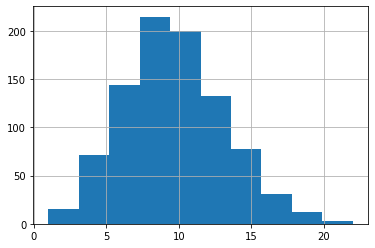

In [135]:
numberFSPsEvts = pd.DataFrame({'count' : nonBsig_FSPs.groupby(["__event__"]).size()}).reset_index()
numberFSPsEvts['count'].hist()

In [136]:
numberFSPsEvts['count'].max()

22

## delete delete_top_numFSP_evts

In [137]:
# print first to adjust percentile used
print("original max FSPs:",numberFSPsEvts["count"].max())
for percentile_lvl in [0.995,0.996,0.997,0.998,0.999]:
    print(percentile_lvl)
    percentile = numberFSPsEvts["count"].quantile(q=percentile_lvl)
    cut_numberFSPsEvts = numberFSPsEvts[numberFSPsEvts["count"] < percentile]
    
    #TMP_df_FSPs = df_FSPs[df_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    TMP_nonBsig_FSPs = nonBsig_FSPs[nonBsig_FSPs['__event__'].isin(cut_numberFSPsEvts["__event__"])]
    
    print("would delete", round(100 - (TMP_nonBsig_FSPs.shape[0]/TMP_nonBsig_FSPs.shape[0])*100,2),"% of evts")
    print("new max FSPs:",cut_numberFSPsEvts["count"].max())

original max FSPs: 22
0.995
would delete 0.0 % of evts
new max FSPs: 18
0.996
would delete 0.0 % of evts
new max FSPs: 18
0.997
would delete 0.0 % of evts
new max FSPs: 19
0.998
would delete 0.0 % of evts
new max FSPs: 20
0.999
would delete 0.0 % of evts
new max FSPs: 21


In [138]:
delete_top_numFSP_evts

False

### impute the nan values of variables

In [139]:
## data preprocessing, dealing with NaN
imputelist = [["pionID",-1.],["kaonID",-1.],["electronID",-1.],["muonID",-1.],["protonID",-1.]
              ,["clusterReg",-1.],["clusterE9E21",-1.]
              ]
for impute in imputelist:
    column_name = impute[0]
    impute_val = impute[1]
    print(nonBsig_FSPs[nonBsig_FSPs[column_name].isna() == True].shape[0])    
    mask = nonBsig_FSPs[column_name].isna() == 1
    nonBsig_FSPs.loc[mask, column_name] = impute_val
    print(nonBsig_FSPs[nonBsig_FSPs[column_name].isna() == True].shape[0])

6573
0
6573
0
6573
0
6573
0
6573
0
258
0
258
0


### check that each particles occurs only ones; count must be == 1 for all

In [140]:
groupsFSPs_uniqParID = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__","uniqueParticleIdentifier"] ).size()}).reset_index()
groupsFSPs_uniqParID.value_counts('count')

count
1    47975
dtype: int64

## save & load labeled and processed df's

### save

In [ ]:
nonBsig_FSPs.to_csv(nfs_path + rawData_subdir +  "nonBsig_FSPs_preProcessed.csv")
Bsig_cand_df.to_csv(nfs_path + "Bsig_cand_df_preProcessed.csv")

### load

In [ ]:
nonBsig_FSPs = pd.read_csv(nfs_path + rawData_subdir +  "nonBsig_FSPs_preProcessed.csv")
Bsig_cand_df = pd.read_csv(nfs_path + rawData_subdir +  "Bsig_cand_df_preProcessed.csv")

# beginning of data prod

In [141]:
df_FSPs_final = nonBsig_FSPs

## definition of input vars to be saved

In [142]:
variable_combinations = [
    [[],"caupi_only4mom"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_allExtras"],
    [["charge","dr","clusterE9E21"],"caupi_chrg_dr_E9E21"],
    [[    "charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_M"],
    [["M",         "dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_charge"],
    [["M","charge",     "dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_dr"],
    [["M","charge","dr",     "clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_dz"],
    [["M","charge","dr","dz",             "clusterE9E21","pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_clReg"],
    [["M","charge","dr","dz","clusterReg",               "pionID","kaonID","electronID","muonID","protonID",
     ],"caupi_no_E9E21"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21",         "kaonID","electronID","muonID","protonID",
     ],"caupi_no_pID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID",         "electronID","muonID","protonID",
     ],"caupi_no_kID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID",             "muonID","protonID",
     ],"caupi_no_eID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID"         ,"protonID",
     ],"caupi_no_muID"],
    [["M","charge","dr","dz","clusterReg","clusterE9E21","pionID","kaonID","electronID","muonID"           ,
     ],"caupi_no_proID"],
    [["charge","pionID","muonID",],"caupi_charge_mpIDs"],
    [["charge"],"caupi_charge"]
]

## start of saving

In [143]:
numFSPs = pd.DataFrame({'count' : df_FSPs_final.groupby( ["__event__"] ).size()}).reset_index()

minFSPs = numFSPs["count"].min()
maxFSPs = numFSPs["count"].max()
print("minFSPs:",minFSPs)
print("maxFSPs:",maxFSPs,'\n')
print("num Events:",numFSPs.shape[0],'\n')

df_FSPs_final['numFSPs'] = df_FSPs_final.groupby('__event__')['__event__'].transform('count')

minFSPs: 1
maxFSPs: 22 

num Events: 902 



In [144]:
now = datetime.now()
print("time at start =", now)

time at start = 2022-01-26 11:52:46.698852


In [145]:
save_data

False

In [152]:
minFSPs = 2 # minimum: Btag: 2 particles
for var_comb in variable_combinations:
    ablationSub = var_comb[1]
    data_dir = Path(nfs_path + data_savedir + "/" + ablationSub + "/")    
    if save_data:
        data_dir.mkdir(parents=True, exist_ok=True)
    print("Will save data to:", data_dir,'is', save_data ,'\n')


    
    for num_FSPs_toData in range(minFSPs, maxFSPs+1):
        df_num_subset = df_FSPs_final.copy()
        df_num_subset = df_num_subset[df_num_subset['numFSPs'] == num_FSPs_toData]


        numEvents = df_num_subset.__event__.nunique()
        print("numEvents:",numEvents)
        print("num_FSPs_toData:",num_FSPs_toData)  
        if numEvents == 0:
            print("skipped because empty \n")
            continue

        if numEvents < 10:
            print("skipped because <10 events \n")
            continue

        num_features = 4 + len(var_comb[0])
        leaves = np.zeros((numEvents, num_FSPs_toData,  num_features))  
        SA_target =  np.zeros((numEvents, num_FSPs_toData))
        global_tag = np.chararray((numEvents, num_FSPs_toData + 1), itemsize=30)

        event_list = df_num_subset[df_num_subset["numFSPs"] == num_FSPs_toData]["__event__"].unique()
        #print("len(event_list):",len(event_list))
        for i in range(numEvents):

            event_iter = event_list[i]

            global_tag_masterInfo = "evt" + str(event_iter)
            global_tag[i,-1] = global_tag_masterInfo
            #print("global_tag[i,-1]:",global_tag[i,-1])
            #print("i:",i,"event_iter:",event_iter)

            event_df = df_num_subset[df_num_subset.__event__ == event_iter]

            for j in range(num_FSPs_toData):
                #print("numParticle:",j)
                particle = event_df.iloc[j]

                #print(particle["mcPDG"],particle["px"],particle["py"],particle["pz"],particle["E"])
                leaves[i,j,0] = particle["px"]
                leaves[i,j,1] = particle["py"]
                leaves[i,j,2] = particle["pz"]
                leaves[i,j,3] = particle["E"]
                
                for k in range(len(var_comb[0])):
                    leav_idx = k + 4
                    leaves[i,j,leav_idx] = particle[var_comb[0][k]]
                    



                global_tag_Info = str((particle["mcPDG"])) 
                global_tag[i,j] = global_tag_Info

        
                SA_target[i,j] = particle["label"]

            del event_df


        # shuffle the data    
        for idx in np.arange(leaves.shape[0]):   # arange is like range but gives ndarray instead of list
            perms = np.random.permutation(leaves.shape[1])

            leaves[idx,:] = leaves[idx,perms]
            SA_target[idx,:] = SA_target[idx,perms]
            global_tag[idx,0:-1] = global_tag[idx,perms]





        #print(global_tag)
        train_ratio = 0.8
        validation_ratio = 0.2
        #test_ratio = 0.1

        print("leaves.shape:",leaves.shape)
        print("SA_target.shape:",SA_target.shape)
        print("global_tag.shape:",global_tag.shape)


        print("leaves[0]:",leaves[0])
        print("SA_target[0]:",SA_target[0])
        print("global_tag[0]:",global_tag[0])

        x=leaves
        y=SA_target
        z=global_tag

        x_train, x_val, y_train, y_val, z_train, z_val = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=1 - train_ratio, shuffle=False)
        #x_val, x_test, y_val, y_test, z_val, z_test = train_test_split(x_test, y_test, z_test, test_size=test_ratio/(test_ratio + validation_ratio), shuffle=False) 

        if save_data==True:
            np.save(data_dir / "leaves_train_FSP{}.npy".format(num_FSPs_toData), x_train)
            np.save(data_dir / "is_left_arr_train_FSP{}.npy".format(num_FSPs_toData), y_train)
            np.save(data_dir / "global_tag_train_FSP{}.npy".format(num_FSPs_toData), z_train)

            np.save(data_dir / "leaves_val_FSP{}.npy".format(num_FSPs_toData), x_val)
            np.save(data_dir / "is_left_arr_val_FSP{}.npy".format(num_FSPs_toData), y_val)
            np.save(data_dir / "global_tag_val_FSP{}.npy".format(num_FSPs_toData), z_val)

            #np.save(data_dir / "leaves_test_FSP{}.npy".format(num_FSPs_toData), x_test)
            #np.save(data_dir / "is_left_arr_test_FSP{}.npy".format(num_FSPs_toData), y_test)
            #np.save(data_dir / "global_tag_test_FSP{}.npy".format(num_FSPs_toData), z_test)


        print("")


        del df_num_subset


Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_only4mom is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 4)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-0.67680848 -1.46234512  1.36247635  2.11282476]
 [-0.3922036   0.86128962  0.3360914   1.01394319]
 [ 0.16057865  0.2128778  -0.20494393  0.33631008]
 [ 0.1533692   0.32385981  0.15231711  0.62874857]]
SA_target[0]: [1. 1. 1. 2.]
global_tag[0]: [b'13.0' b'211.0' b'-11.0' b'321.0' b'evt2333793']

numEvents: 43
num_FSPs_toData: 5
leaves.shape: (43, 5, 4)
SA_target.shape: (43, 5)
global_tag.shape: (43, 6)
leaves[0]: [[ 0.87829417 -0.21939826  0.49162069  1.14234151]
 [-0.82585287 -0.08352644  0.15057257  0.97744499]
 [-0.24228321  0.97915286  0.29055333  1.05893466]
 [ 0.11174456 -0.09678835  0.27128986  0.30895472]
 [ 0.11773076 -0.


numEvents: 34
num_FSPs_toData: 15
leaves.shape: (34, 15, 4)
SA_target.shape: (34, 15)
global_tag.shape: (34, 16)
leaves[0]: [[ 0.34202871 -0.02068509  0.16995619  0.38248741]
 [ 0.01532213 -0.01847112 -0.02734218  0.03638056]
 [-0.07649471 -0.05852882 -0.05313121  0.10999995]
 [-0.03334333  0.00637139  0.06177771  0.07049012]
 [-0.3881942   0.03545798  0.09334651  0.40083111]
 [ 0.62608236  0.064126   -0.02513221  0.80027487]
 [-0.01505885  0.10035681  0.0294938   0.10567943]
 [ 0.00636963  0.50031519  0.19967881  0.55651359]
 [ 0.01569666  0.04284288  0.08818367  0.09928876]
 [-0.06089982  0.07894062  0.13994452  0.17182805]
 [-0.09812178  0.06009625  0.03332219  0.1197907 ]
 [ 0.27727869  0.03283118  0.26446614  0.3845825 ]
 [ 0.10309108  0.47693461  0.70671755  0.99058622]
 [-0.18063293 -0.15164661  0.24738252  0.34179389]
 [ 0.18200372 -0.3027105   0.09805521  0.39224192]]
SA_target[0]: [1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 2. 1. 1.]
global_tag[0]: [b'22.0' b'nan' b'22.0' b'nan' b'


numEvents: 94
num_FSPs_toData: 7
leaves.shape: (94, 7, 15)
SA_target.shape: (94, 7)
global_tag.shape: (94, 8)
leaves[0]: [[ 1.12834200e-02  8.20783302e-02  1.04823284e-01  1.33611709e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.18105356e-02 -1.99867748e-02  5.27075976e-02  5.75938431e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 7.19473371e-03  1.66749462e-01  5.19607700e-02  1.74805804e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.18945312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-4.50552374e-01  5.71719229e-01  2.20249057e-01  9.06690100e-01
   4.93676990e-01  1.00000000e+00  1.02567695e-02  9.96306978e-02


numEvents: 103
num_FSPs_toData: 11
leaves.shape: (103, 11, 15)
SA_target.shape: (103, 11)
global_tag.shape: (103, 12)
leaves[0]: [[ 3.78077216e-02  7.09360391e-02 -9.51899663e-02  1.24589226e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   3.00000000e+00  9.01367188e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 7.93839693e-02 -3.65654868e-03  6.15362972e-02  1.00508213e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.50195312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.87200455e-02 -6.93172514e-02  9.50589031e-02  1.21102921e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.92187500e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.78025359e-01 -6.32073283e-02  6.84988499e-01  7.41958563e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.2351


numEvents: 44
num_FSPs_toData: 14
leaves.shape: (44, 14, 15)
SA_target.shape: (44, 14)
global_tag.shape: (44, 15)
leaves[0]: [[ 2.72289477e-03 -4.17298526e-02  2.11326275e-02  4.68549111e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.81445312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.50513166e-01  1.30621001e-01  8.43415111e-02  2.94842641e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.58007812e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.48837899e-02 -2.31665261e-02 -2.05170773e-02  3.97094623e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-5.92398047e-02 -7.36470819e-01  4.26273584e-01  8.52999291e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418


numEvents: 13
num_FSPs_toData: 17
leaves.shape: (13, 17, 15)
SA_target.shape: (13, 17)
global_tag.shape: (13, 18)
leaves[0]: [[-5.11524618e-001 -6.74294114e-001  5.84534883e-001  1.14093295e+000
   4.93676990e-001 -1.00000000e+000  5.66663796e-003  1.20416075e-002
   2.00000000e+000  8.95507812e-001  7.16966408e-010  9.99999999e-001
   7.03400377e-015  1.42843412e-015  9.04112623e-012]
 [ 9.53983739e-002 -2.09491730e-001 -2.02448815e-001  3.06550416e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   3.00000000e+000  9.51171875e-001 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [ 8.78734291e-002 -8.27259049e-002 -3.81672569e-002  1.26578254e-001
   0.00000000e+000  0.00000000e+000  1.18686603e-009  2.23517418e-010
   2.00000000e+000  1.00000000e+000 -1.00000000e+000 -1.00000000e+000
  -1.00000000e+000 -1.00000000e+000 -1.00000000e+000]
 [-2.92117521e-003 -3.03090047e-002  1.57527719e-002  3.42829236e-002
   0.0000000


numEvents: 103
num_FSPs_toData: 8
leaves.shape: (103, 8, 7)
SA_target.shape: (103, 8)
global_tag.shape: (103, 9)
leaves[0]: [[ 1.76514223e-01  9.52016860e-02  1.08012840e-01  2.27788072e-01
   0.00000000e+00  1.18686603e-09  9.87304688e-01]
 [ 7.05663681e-01 -3.24361473e-01  8.05348873e-01  1.22289631e+00
  -1.00000000e+00  1.21373189e-03  7.74414062e-01]
 [ 1.25273213e-01  1.38520896e-01  1.33358583e-01  2.29490584e-01
   0.00000000e+00  1.18686603e-09  9.79492188e-01]
 [-2.48339891e-01 -2.17285946e-01 -1.67515382e-01  3.70063896e-01
   0.00000000e+00  1.18686603e-09  9.94140625e-01]
 [ 3.33748125e-02  9.58189666e-02 -6.79230690e-02  1.22101170e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 1.00973874e-01 -6.48560002e-03  7.30409697e-02  1.24790903e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 4.24945727e-02  2.65144221e-02  1.11444719e-01  1.22183177e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-1.56975929e-02  1.61901236e-01 -2.57687628e-01  3.047


numEvents: 44
num_FSPs_toData: 14
leaves.shape: (44, 14, 7)
SA_target.shape: (44, 14)
global_tag.shape: (44, 15)
leaves[0]: [[ 1.76164627e-01 -1.65590495e-01 -2.80179735e-02  2.43391032e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-5.18487282e-02  8.58408511e-02  2.91860364e-02  1.04445043e-01
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-1.56538248e-01  1.29368911e-02 -2.34199222e-02  1.58808309e-01
   0.00000000e+00  1.18686603e-09  9.74609375e-01]
 [ 2.48837899e-02 -2.31665261e-02 -2.05170773e-02  3.97094623e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [-1.26426900e-02 -3.75192575e-02  3.48395742e-02  5.27382994e-02
   0.00000000e+00  1.18686603e-09  1.00000000e+00]
 [ 1.28364801e-01 -4.26066995e-01  4.30812031e-01  6.19362263e-01
   0.00000000e+00  1.18686603e-09  9.91210938e-01]
 [ 2.55956322e-01  2.73518175e-01 -1.53624445e-01  6.38469476e-01
  -1.00000000e+00  1.23371044e-03  1.00000000e+00]
 [ 2.50513166e-01  1.30621001e-01  8.43415111e-02  2.948


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_M is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.00000000e+00  4.04703617e-01  5.24014270e-01  2.00000000e+00
   8.48632812e-01  9.98990785e-01  2.72786176e-08  1.00717400e-03
   2.01353537e-06  1.32966598e-24]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   1.00000000e+00  3.46609719e-03 


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[ 2.70271122e-01 -1.92989439e-01 -1.67860612e-01  3.72113677e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.93164062e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.62138373e-01  3.96510437e-02  3.06786615e-02  1.69712219e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.99023438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.76562500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
  -1.00000000e+00  1.72341498e-02  1.21715518e-02  2.00000000e+00
   9.66796875e-01  7.97505001e-01  1.19785


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[ 3.56420353e-02  3.93383717e-03  7.90115893e-02  8.67678569e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   9.55078125e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.29180574e-01  3.24571282e-01 -5.97653724e-02  4.01798646e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.86328125e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.73062354e-01  3.70967925e-01  1.12884626e-01  4.24630096e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.49218750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-4.63829748e-02 -5.25840968e-02  8.71979296e-02  1.11892567e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[-2.16354743e-01 -1.35470971e-01 -1.13732845e-01  2.79458259e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.61914062e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.27768177e-02  5.32217883e-03 -4.22396436e-02  5.37292551e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  3.00000000e+00
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.19534780e-02 -5.64407110e-02 -1.93418302e-02  7.29366477e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.09309936e-01 -5.27988710e-02  1.25391200e-01  2.49642390e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_charge is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[ 1.60578653e-01  2.12877795e-01 -2.04943925e-01  3.36310083e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.91210938e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-6.76808476e-01 -1.46234512e+00  1.36247635e+00  2.11282476e+00
   1.05658367e-01  2.66390956


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.60937500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01  2.14491060e-03  1.70352073e-02  2.00000000e+00
   9.99023438e-01  2.94476431e-01  6.91059766e-01  1.44638027e-02
   4.63587241e-10  1.12009954e-11]
 [-1.62138373e-01  3.96510437e-02  3.06786615e-02  1.69712219e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.99023438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.70271122e-01 -1.92989439e-01 -1.67860612e-01  3.72113677e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.93164062e-01 -1.00000000e+00 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[ 2.61500627e-01  1.94242850e-01 -1.49495080e-01  6.10064433e-01
   4.93676990e-01  6.81433468e-03  2.25801760e-02 -1.00000000e+00
  -1.00000000e+00  1.07118794e-10  9.99834149e-01  3.45843768e-21
   4.70395848e-12  1.56094211e-04]
 [-6.36324883e-02  3.40800993e-02 -4.73040454e-02  8.63030674e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.73062354e-01  3.70967925e-01  1.12884626e-01  4.24630096e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.49218750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.29180574e-01  3.24571282e-01 -5.97653724e-02  4.01798646e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   9.86328125e-01 -1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[ 4.19534780e-02 -5.64407110e-02 -1.93418302e-02  7.29366477e-02
   0.00000000e+00  1.18686603e-09  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.78204177e-02  4.12798822e-01 -2.12503269e-01  4.85607223e-01
   1.39570385e-01  3.79123572e-03  6.79840469e-02  2.00000000e+00
   8.80859375e-01  9.99986895e-01  6.52005708e-24  3.35949729e-13
   1.31046435e-05  1.35473762e-42]
 [ 8.29058513e-02  5.10014333e-02  2.73624748e-01  2.90422157e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   9.80468750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.62081480e-01  3.20832767e-02  3.38717669e-01  3.76867884e-01
   0.00000000e+00  1.18686603e-09  2.23517418e-10  1.00000000e+00
   9.17968750e-01 -1.00000000e+00 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_dr is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-6.76808476e-01 -1.46234512e+00  1.36247635e+00  2.11282476e+00
   1.05658367e-01 -1.00000000e+00 -2.66400059e-02  2.00000000e+00
   1.00000000e+00  3.21165929e-12  6.28356131e-14  1.11414739e-45
   1.00000000e+00  7.10640323e-27]
 [ 1.60578653e-01  2.12877795e-01 -2.04943925e-01  3.36310083e-01
   0.00000000e+00  0.00000000e+00


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01 -1.00000000e+00  1.70352073e-02  2.00000000e+00
   9.99023438e-01  2.94476431e-01  6.91059766e-01  1.44638027e-02
   4.63587241e-10  1.12009954e-11]
 [-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  2.06251735e-02  1.00000000e+00
   9.85351562e-01  1.92049491e-06  3.35104032e-18  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.60937500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.76562500e-01 -1.00000000e+00 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[-4.63829748e-02 -5.25840968e-02  8.71979296e-02  1.11892567e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.70064077e-01 -1.72137395e-02  3.41267765e-01  3.81682840e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.60936677e-01 -4.13185507e-01 -2.94263978e-02  4.89567284e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.95117188e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.08981801e-02 -5.00312522e-02  7.89728835e-02  9.57944490e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   9.74609375e-01 -1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[ 8.29058513e-02  5.10014333e-02  2.73624748e-01  2.90422157e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  1.00000000e+00
   9.80468750e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.27618304e-02 -5.37494011e-02 -7.60345161e-02  9.39846268e-02
   0.00000000e+00  0.00000000e+00  2.23517418e-10  3.00000000e+00
   9.58007812e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.87450194e-01  7.95062259e-02  8.51111352e-01  1.26273772e+00
   4.93676990e-01  1.00000000e+00  8.69389602e-02  2.00000000e+00
   9.84375000e-01  6.19880533e-14  1.00000000e+00  1.51674018e-18
   2.07609312e-15  1.04672660e-41]
 [ 2.09309936e-01 -5.27988710e-02  1.25391200e-01  2.49642390e-01
   0.00000000e+00  0.00000000e+00  2.23517418e-10  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_dz is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-6.76808476e-01 -1.46234512e+00  1.36247635e+00  2.11282476e+00
   1.05658367e-01 -1.00000000e+00  2.66390956e-03  2.00000000e+00
   1.00000000e+00  3.21165929e-12  6.28356131e-14  1.11414739e-45
   1.00000000e+00  7.10640323e-27]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+00


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.60937500e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.62138373e-01  3.96510437e-02  3.06786615e-02  1.69712219e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.99023438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  1.00000000e+00
   9.85351562e-01  1.92049491e-06  3.35104032e-18  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.76562500e-01 -1.00000000e+00 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[-2.29180574e-01  3.24571282e-01 -5.97653724e-02  4.01798646e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.86328125e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.70064077e-01 -1.72137395e-02  3.41267765e-01  3.81682840e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  1.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.27935395e-01  4.35706645e-01  1.55593408e-02  4.54367515e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.86328125e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.08981801e-02 -5.00312522e-02  7.89728835e-02  9.57944490e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.74609375e-01 -1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[ 7.14862123e-02 -7.28309005e-02  1.50350571e-01  1.81713821e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.27768177e-02  5.32217883e-03 -4.22396436e-02  5.37292551e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  3.00000000e+00
   9.25781250e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.90808970e-01  2.66621783e-02  8.05561021e-02  3.99914751e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.81445312e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.70019078e-01 -1.88382283e-01  1.24191932e-01  4.33388554e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.00000000e+00
   9.82421875e-01 -1.00000000e+00 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_clReg is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-6.76808476e-01 -1.46234512e+00  1.36247635e+00  2.11282476e+00
   1.05658367e-01 -1.00000000e+00  2.66390956e-03 -2.66400059e-02
   1.00000000e+00  3.21165929e-12  6.28356131e-14  1.11414739e-45
   1.00000000e+00  7.10640323e-27]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  2.06251735e-02
   9.85351562e-01  1.92049491e-06  3.35104032e-18  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01 -1.00000000e+00  2.14491060e-03  1.70352073e-02
   9.99023438e-01  2.94476431e-01  6.91059766e-01  1.44638027e-02
   4.63587241e-10  1.12009954e-11]
 [-1.62138373e-01  3.96510437e-02  3.06786615e-02  1.69712219e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.99023438e-01 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
   1.39570385e-01 -1.00000000e+00  1.72341498e-02  1.21715518e-02
   9.66796875e-01  7.97505001e-01  1.19785


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[-4.63829748e-02 -5.25840968e-02  8.71979296e-02  1.11892567e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.61500627e-01  1.94242850e-01 -1.49495080e-01  6.10064433e-01
   4.93676990e-01  1.00000000e+00  6.81433468e-03  2.25801760e-02
  -1.00000000e+00  1.07118794e-10  9.99834149e-01  3.45843768e-21
   4.70395848e-12  1.56094211e-04]
 [-6.36324883e-02  3.40800993e-02 -4.73040454e-02  8.63030674e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.60936677e-01 -4.13185507e-01 -2.94263978e-02  4.89567284e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   9.95117188e-01 -1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[-2.78204177e-02  4.12798822e-01 -2.12503269e-01  4.85607223e-01
   1.39570385e-01 -1.00000000e+00  3.79123572e-03  6.79840469e-02
   8.80859375e-01  9.99986895e-01  6.52005708e-24  3.35949729e-13
   1.31046435e-05  1.35473762e-42]
 [ 7.14862123e-02 -7.28309005e-02  1.50350571e-01  1.81713821e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.19534780e-02 -5.64407110e-02 -1.93418302e-02  7.29366477e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.87450194e-01  7.95062259e-02  8.51111352e-01  1.26273772e+00
   4.93676990e-01  1.00000000e+00  4.19576996e-03  8.69389602e-02
   9.84375000e-01  6.19880533e-14  1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_E9E21 is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.39570385e-01  1.00000000e+00  4.04703617e-01  5.24014270e-01
   2.00000000e+00  9.98990785e-01  2.72786176e-08  1.00717400e-03
   2.01353537e-06  1.32966598e-24]
 [ 1.60578653e-01  2.12877795e-01 -2.04943925e-01  3.36310083e-01
   0.00000000e+00  0.00000000e


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
   1.39570385e-01 -1.00000000e+00  1.72341498e-02  1.21715518e-02
   2.00000000e+00  7.97505001e-01  1.19785858e-01  2.65881739e-05
   1.44556328e-12  8.26825530e-02]
 [-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  2.06251735e-02
   1.00000000e+00  1.92049491e-06  3.35104032e-18  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [-2.32570842e-02 -2.06365995e-02  5.54825999e-02  6.36009441e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.70271122e-01 -1.92989439e-01 -1.67860612e-01  3.72113677e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[-9.42987502e-02  1.62391052e-01 -1.05375066e-01  2.15330008e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.56420353e-02  3.93383717e-03  7.90115893e-02  8.67678569e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.82364863e-01 -5.68556711e-02 -2.01975599e-01  5.44226482e-01
   1.39570385e-01 -1.00000000e+00  1.00801132e-02  2.56822427e-02
   2.00000000e+00  1.00000000e+00  7.24260145e-60  1.27250629e-25
   2.26280483e-14  8.05441619e-81]
 [ 2.08981801e-02 -5.00312522e-02  7.89728835e-02  9.57944490e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[-2.78204177e-02  4.12798822e-01 -2.12503269e-01  4.85607223e-01
   1.39570385e-01 -1.00000000e+00  3.79123572e-03  6.79840469e-02
   2.00000000e+00  9.99986895e-01  6.52005708e-24  3.35949729e-13
   1.31046435e-05  1.35473762e-42]
 [ 3.90808970e-01  2.66621783e-02  8.05561021e-02  3.99914751e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.33428981e-02 -5.57482056e-02  4.67120335e-02  7.63856491e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.16354743e-01 -1.35470971e-01 -1.13732845e-01  2.79458259e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00 -1.00000000e+00 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_pID is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+00  3.46609719e-03 -2.25171518e-02
   2.00000000e+00  9.81445312e-01  1.00000000e+00  9.65053434e-53
   6.93454036e-92  5.07812714e-23]
 [-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.39570385e-01  1.00000000e+0


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.76562500e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.32570842e-02 -2.06365995e-02  5.54825999e-02  6.36009441e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.81445312e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  2.06251735e-02
   1.00000000e+00  9.85351562e-01  3.35104032e-18  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [ 2.70271122e-01 -1.92989439e-01 -1.67860612e-01  3.72113677e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.93164062e-01 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[ 2.08981801e-02 -5.00312522e-02  7.89728835e-02  9.57944490e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.74609375e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.61500627e-01  1.94242850e-01 -1.49495080e-01  6.10064433e-01
   4.93676990e-01  1.00000000e+00  6.81433468e-03  2.25801760e-02
  -1.00000000e+00 -1.00000000e+00  9.99834149e-01  3.45843768e-21
   4.70395848e-12  1.56094211e-04]
 [ 1.73062354e-01  3.70967925e-01  1.12884626e-01  4.24630096e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.49218750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.82364863e-01 -5.68556711e-02 -2.01975599e-01  5.44226482e-01
   1.39570385e-01 -1.00000000e+00  1.00801132e-02  2.56822427e-02
   2.00000000e+00  8.91601562e-01  7.242601


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[-2.16354743e-01 -1.35470971e-01 -1.13732845e-01  2.79458259e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.61914062e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.27768177e-02  5.32217883e-03 -4.22396436e-02  5.37292551e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   3.00000000e+00  9.25781250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-2.78204177e-02  4.12798822e-01 -2.12503269e-01  4.85607223e-01
   1.39570385e-01 -1.00000000e+00  3.79123572e-03  6.79840469e-02
   2.00000000e+00  8.80859375e-01  6.52005708e-24  3.35949729e-13
   1.31046435e-05  1.35473762e-42]
 [ 4.19534780e-02 -5.64407110e-02 -1.93418302e-02  7.29366477e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_kID is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.39570385e-01  1.00000000e+00  4.04703617e-01  5.24014270e-01
   2.00000000e+00  8.48632812e-01  9.98990785e-01  1.00717400e-03
   2.01353537e-06  1.32966598e-24]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+0


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
   1.39570385e-01 -1.00000000e+00  1.72341498e-02  1.21715518e-02
   2.00000000e+00  9.66796875e-01  7.97505001e-01  2.65881739e-05
   1.44556328e-12  8.26825530e-02]
 [-1.62138373e-01  3.96510437e-02  3.06786615e-02  1.69712219e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.99023438e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  2.06251735e-02
   1.00000000e+00  9.85351562e-01  1.92049491e-06  9.99998080e-01
   4.33379893e-14  8.53238893e-15]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.76562500e-01 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[ 1.70064077e-01 -1.72137395e-02  3.41267765e-01  3.81682840e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-3.06209121e-02 -1.45463394e-02  6.82350108e-03  3.45802894e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.82364863e-01 -5.68556711e-02 -2.01975599e-01  5.44226482e-01
   1.39570385e-01 -1.00000000e+00  1.00801132e-02  2.56822427e-02
   2.00000000e+00  8.91601562e-01  1.00000000e+00  1.27250629e-25
   2.26280483e-14  8.05441619e-81]
 [ 1.27935395e-01  4.35706645e-01  1.55593408e-02  4.54367515e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.86328125e-01 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[-1.62081480e-01  3.20832767e-02  3.38717669e-01  3.76867884e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.17968750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 8.29058513e-02  5.10014333e-02  2.73624748e-01  2.90422157e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.80468750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.09309936e-01 -5.27988710e-02  1.25391200e-01  2.49642390e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.87450194e-01  7.95062259e-02  8.51111352e-01  1.26273772e+00
   4.93676990e-01  1.00000000e+00  4.19576996e-03  8.69389602e-02
   2.00000000e+00  9.84375000e-01  6.198805


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_eID is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.39570385e-01  1.00000000e+00  4.04703617e-01  5.24014270e-01
   2.00000000e+00  8.48632812e-01  9.98990785e-01  2.72786176e-08
   2.01353537e-06  1.32966598e-24]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+0


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  2.06251735e-02
   1.00000000e+00  9.85351562e-01  1.92049491e-06  3.35104032e-18
   4.33379893e-14  8.53238893e-15]
 [-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01 -1.00000000e+00  2.14491060e-03  1.70352073e-02
   2.00000000e+00  9.99023438e-01  2.94476431e-01  6.91059766e-01
   4.63587241e-10  1.12009954e-11]
 [ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
   1.39570385e-01 -1.00000000e+00  1.72341498e-02  1.21715518e-02
   2.00000000e+00  9.66796875e-01  7.97505001e-01  1.19785858e-01
   1.44556328e-12  8.26825530e-02]
 [-7.48464614e-02  1.52275413e-02  9.41361561e-02  1.21224943e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.76562500e-01 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[ 1.70064077e-01 -1.72137395e-02  3.41267765e-01  3.81682840e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.61500627e-01  1.94242850e-01 -1.49495080e-01  6.10064433e-01
   4.93676990e-01  1.00000000e+00  6.81433468e-03  2.25801760e-02
  -1.00000000e+00 -1.00000000e+00  1.07118794e-10  9.99834149e-01
   4.70395848e-12  1.56094211e-04]
 [ 4.82364863e-01 -5.68556711e-02 -2.01975599e-01  5.44226482e-01
   1.39570385e-01 -1.00000000e+00  1.00801132e-02  2.56822427e-02
   2.00000000e+00  8.91601562e-01  1.00000000e+00  7.24260145e-60
   2.26280483e-14  8.05441619e-81]
 [ 1.73062354e-01  3.70967925e-01  1.12884626e-01  4.24630096e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.49218750e-01 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[ 7.14862123e-02 -7.28309005e-02  1.50350571e-01  1.81713821e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.91690701e-01 -8.20302516e-02  5.70976973e-01  8.54331459e-01
   4.93676990e-01  1.00000000e+00  1.41873818e-02  9.91695824e-02
   1.00000000e+00  9.40429688e-01  1.37771802e-11  9.99953773e-01
   3.41605259e-13  4.62272237e-05]
 [ 8.29058513e-02  5.10014333e-02  2.73624748e-01  2.90422157e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.80468750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.62081480e-01  3.20832767e-02  3.38717669e-01  3.76867884e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.17968750e-01 -1.000000


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_muID is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.39570385e-01  1.00000000e+00  4.04703617e-01  5.24014270e-01
   2.00000000e+00  8.48632812e-01  9.98990785e-01  2.72786176e-08
   1.00717400e-03  1.32966598e-24]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e+


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[ 2.70271122e-01 -1.92989439e-01 -1.67860612e-01  3.72113677e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.93164062e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01 -1.00000000e+00  2.14491060e-03  1.70352073e-02
   2.00000000e+00  9.99023438e-01  2.94476431e-01  6.91059766e-01
   1.44638027e-02  1.12009954e-11]
 [ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
   1.39570385e-01 -1.00000000e+00  1.72341498e-02  1.21715518e-02
   2.00000000e+00  9.66796875e-01  7.97505001e-01  1.19785858e-01
   2.65881739e-05  8.26825530e-02]
 [ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.60937500e-01 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[-2.29180574e-01  3.24571282e-01 -5.97653724e-02  4.01798646e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.86328125e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 1.73062354e-01  3.70967925e-01  1.12884626e-01  4.24630096e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.49218750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.82364863e-01 -5.68556711e-02 -2.01975599e-01  5.44226482e-01
   1.39570385e-01 -1.00000000e+00  1.00801132e-02  2.56822427e-02
   2.00000000e+00  8.91601562e-01  1.00000000e+00  7.24260145e-60
   1.27250629e-25  8.05441619e-81]
 [-9.42987502e-02  1.62391052e-01 -1.05375066e-01  2.15330008e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[ 2.69454275e-03  8.78542066e-02  8.30827728e-02  1.20947796e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.87450194e-01  7.95062259e-02  8.51111352e-01  1.26273772e+00
   4.93676990e-01  1.00000000e+00  4.19576996e-03  8.69389602e-02
   2.00000000e+00  9.84375000e-01  6.19880533e-14  1.00000000e+00
   1.51674018e-18  1.04672660e-41]
 [-3.27768177e-02  5.32217883e-03 -4.22396436e-02  5.37292551e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   3.00000000e+00  9.25781250e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.91690701e-01 -8.20302516e-02  5.70976973e-01  8.54331459e-01
   4.93676990e-01  1.00000000e+00  1.41873818e-02  9.91695824e-02
   1.00000000e+00  9.40429688e-01  1.377718


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_no_proID is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 14)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[-6.76808476e-01 -1.46234512e+00  1.36247635e+00  2.11282476e+00
   1.05658367e-01 -1.00000000e+00  2.66390956e-03 -2.66400059e-02
   2.00000000e+00  1.00000000e+00  3.21165929e-12  6.28356131e-14
   1.11414739e-45  1.00000000e+00]
 [ 1.53369203e-01  3.23859811e-01  1.52317107e-01  6.28748568e-01
   4.93676990e-01  1.00000000e


numEvents: 112
num_FSPs_toData: 9
leaves.shape: (112, 9, 14)
SA_target.shape: (112, 9)
global_tag.shape: (112, 10)
leaves[0]: [[-8.85372877e-01  5.11225760e-01  1.04650147e-01  1.14013400e+00
   4.93676990e-01 -1.00000000e+00  2.14491060e-03  1.70352073e-02
   2.00000000e+00  9.99023438e-01  2.94476431e-01  6.91059766e-01
   1.44638027e-02  4.63587241e-10]
 [ 1.19008221e-01  1.23844349e+00  2.60778069e-01  1.27882381e+00
   1.39570385e-01 -1.00000000e+00  1.72341498e-02  1.21715518e-02
   2.00000000e+00  9.66796875e-01  7.97505001e-01  1.19785858e-01
   2.65881739e-05  1.44556328e-12]
 [-8.20775211e-01 -5.45055866e-01  1.84322560e+00  2.09003318e+00
   5.10998943e-04 -1.00000000e+00  1.62276028e-03  2.06251735e-02
   1.00000000e+00  9.85351562e-01  1.92049491e-06  3.35104032e-18
   9.99998080e-01  4.33379893e-14]
 [ 1.98220015e-01 -3.22186351e-02 -1.32470012e-01  2.40577469e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.60937500e-01 -1.00000


numEvents: 63
num_FSPs_toData: 13
leaves.shape: (63, 13, 14)
SA_target.shape: (63, 13)
global_tag.shape: (63, 14)
leaves[0]: [[ 1.73062354e-01  3.70967925e-01  1.12884626e-01  4.24630096e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.49218750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 4.82364863e-01 -5.68556711e-02 -2.01975599e-01  5.44226482e-01
   1.39570385e-01 -1.00000000e+00  1.00801132e-02  2.56822427e-02
   2.00000000e+00  8.91601562e-01  1.00000000e+00  7.24260145e-60
   1.27250629e-25  2.26280483e-14]
 [ 1.70064077e-01 -1.72137395e-02  3.41267765e-01  3.81682840e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 2.08981801e-02 -5.00312522e-02  7.89728835e-02  9.57944490e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.74609375e-01 -1.000000


numEvents: 18
num_FSPs_toData: 16
leaves.shape: (18, 16, 14)
SA_target.shape: (18, 16)
global_tag.shape: (18, 17)
leaves[0]: [[-1.62081480e-01  3.20832767e-02  3.38717669e-01  3.76867884e-01
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   1.00000000e+00  9.17968750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-7.87450194e-01  7.95062259e-02  8.51111352e-01  1.26273772e+00
   4.93676990e-01  1.00000000e+00  4.19576996e-03  8.69389602e-02
   2.00000000e+00  9.84375000e-01  6.19880533e-14  1.00000000e+00
   1.51674018e-18  2.07609312e-15]
 [-2.33428981e-02 -5.57482056e-02  4.67120335e-02  7.63856491e-02
   0.00000000e+00  0.00000000e+00  1.18686603e-09  2.23517418e-10
   2.00000000e+00  9.49218750e-01 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [ 3.91690701e-01 -8.20302516e-02  5.70976973e-01  8.54331459e-01
   4.93676990e-01  1.00000000e+00  1.41873818e-02  9.91695824e-02
   1.00000000e+00  9.40429688e-01  1.377718


numEvents: 9
num_FSPs_toData: 18
skipped because <10 events 

numEvents: 3
num_FSPs_toData: 19
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 20
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 21
skipped because <10 events 

numEvents: 1
num_FSPs_toData: 22
skipped because <10 events 

Will save data to: /nfs/dust/belle2/user/axelheim/MC_studies/ROEcleanup/caupi/data/firstRun/caupi_charge_mpIDs is True 

numEvents: 4
num_FSPs_toData: 2
skipped because <10 events 

numEvents: 9
num_FSPs_toData: 3
skipped because <10 events 

numEvents: 28
num_FSPs_toData: 4
leaves.shape: (28, 4, 7)
SA_target.shape: (28, 4)
global_tag.shape: (28, 5)
leaves[0]: [[ 1.60578653e-01  2.12877795e-01 -2.04943925e-01  3.36310083e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-6.76808476e-01 -1.46234512e+00  1.36247635e+00  2.11282476e+00
  -1.00000000e+00  3.21165929e-12  1.00000000e+00]
 [-3.92203599e-01  8.61289620e-01  3.36091399e-01  1.01394319e+00
   1.00000000e+00  9.98990


numEvents: 70
num_FSPs_toData: 12
leaves.shape: (70, 12, 7)
SA_target.shape: (70, 12)
global_tag.shape: (70, 13)
leaves[0]: [[ 4.72748615e-02 -7.57849589e-02 -1.00634478e-01  1.34556942e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-2.14442089e-01 -5.22113323e-01 -1.83930308e-01  6.09834389e-01
  -1.00000000e+00  9.82769391e-01  1.72243206e-02]
 [-7.97002576e-03 -2.76856143e-02  4.86796871e-02  5.65661249e-02
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.58191228e-01 -4.95468080e-02  2.10848927e-01  3.37008704e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-3.47819030e-02 -1.10785579e-02 -6.85080215e-02  7.76264403e-02
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-4.37171161e-02 -1.16682075e-01  5.81112280e-02  1.37487482e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.10916039e-02  5.04791886e-02  5.82754314e-02  7.78922208e-02
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 1.62967071e-02  2.58678552e-02  6.85473252e-03  3.133


numEvents: 13
num_FSPs_toData: 17
leaves.shape: (13, 17, 7)
SA_target.shape: (13, 17)
global_tag.shape: (13, 18)
leaves[0]: [[ 9.53983739e-02 -2.09491730e-01 -2.02448815e-01  3.06550416e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 8.78734291e-02 -8.27259049e-02 -3.81672569e-02  1.26578254e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-2.14716062e-01  2.13737965e-01  2.80806333e-01  4.36026368e-01
   1.00000000e+00  9.98593740e-01  1.40625986e-03]
 [ 8.44008401e-02  3.50738689e-02  2.12066263e-01  2.30923749e-01
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 4.38437760e-02 -6.52858168e-02  5.63045107e-02  9.67197627e-02
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 7.63550308e-03  7.78449103e-02  1.16589963e-02  7.90826350e-02
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [-2.92117521e-03 -3.03090047e-02  1.57527719e-02  3.42829236e-02
   0.00000000e+00 -1.00000000e+00 -1.00000000e+00]
 [ 2.25219041e-01 -5.19237369e-02  2.65145004e-01  3.517


numEvents: 70
num_FSPs_toData: 12
leaves.shape: (70, 12, 5)
SA_target.shape: (70, 12)
global_tag.shape: (70, 13)
leaves[0]: [[-0.00797003 -0.02768561  0.04867969  0.05656612  0.        ]
 [ 0.04727486 -0.07578496 -0.10063448  0.13455694  0.        ]
 [-0.07646204  0.09520093 -0.02878217  0.12545148  0.        ]
 [ 0.01629671  0.02586786  0.00685473  0.03133235  0.        ]
 [ 0.0110916   0.05047919  0.05827543  0.07789222  0.        ]
 [ 0.25819123 -0.04954681  0.21084893  0.3370087   0.        ]
 [ 0.38604733  0.04754635 -0.27889061  0.68759737  1.        ]
 [-0.21444209 -0.52211332 -0.18393031  0.60983439 -1.        ]
 [-0.0347819  -0.01107856 -0.06850802  0.07762644  0.        ]
 [-0.04371712 -0.11668207  0.05811123  0.13748748  0.        ]
 [-0.4693366   0.42533225  0.01625346  0.64878998 -1.        ]
 [-0.05466076 -0.00794597  0.12635836  0.13790349  0.        ]]
SA_target[0]: [1. 1. 1. 1. 1. 1. 1. 1. 0. 2. 1. 2.]
global_tag[0]: [b'22.0' b'22.0' b'-211.0' b'22.0' b'22.0' b'22.0' 

In [53]:
print("saving is done")
now = datetime.now()
print("time at end =", now)

saving is done
time at end = 2022-01-26 11:30:35.369499


## additional analysis on Bsig correctness

In [81]:
FSPs_noDuplis['B_ID'] = FSPs_noDuplis.apply(B_ID, axis=1)

In [83]:
FSPs_noDuplis['B_ID'].value_counts()

83886082    20376
83886081    20249
0            7350
Name: B_ID, dtype: int64

In [85]:
print(FSPs_noDuplis.shape[0])
FSPs_noDuplis = pd.merge(FSPs_noDuplis, Bsig_cand_df[["__event__","Bsig_uniqParID"]], on="__event__")
print(FSPs_noDuplis.shape[0])

47975
47975


In [86]:
FSPs_noDuplis["genBsig_descendant"] = (FSPs_noDuplis["B_ID"] == FSPs_noDuplis["Bsig_uniqParID"]).astype(int)

In [87]:
FSPs_noDuplis['genBsig_descendant'].describe()

count    47975.000000
mean         0.308473
std          0.461868
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: genBsig_descendant, dtype: float64

In [88]:
Bsig_cand_df["Bsig_genParticleID"].value_counts()

0.0    2400
2.0     105
1.0     102
Name: Bsig_genParticleID, dtype: int64

In [89]:
genBsigs = pd.DataFrame({'count' : Bsig_cand_df.groupby( ["Bsig_genParticleID","Bsig_uniqParID"] ).size()}).reset_index()
genBsigs

,Bsig_genParticleID,Bsig_uniqParID,count
0,0.0,83886081.0,1227
1,0.0,83886082.0,1173
2,1.0,83886081.0,100
3,1.0,83886082.0,2
4,2.0,83886081.0,19
5,2.0,83886082.0,86


In [90]:
tmp = Bsig_cand_df[((((Bsig_cand_df["Bsig_genParticleID"] == 1.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886081.0))) | 
                   ((Bsig_cand_df["Bsig_genParticleID"] == 2.0) & (Bsig_cand_df["Bsig_uniqParID"] == 83886082.0)))]
print(tmp.shape[0])

tmpFSPs = FSPs_noDuplis[FSPs_noDuplis['__event__'].isin(tmp["__event__"])]


tmpFSPs['genBsig_descendant'].describe()

186


count    2105.000000
mean        0.323040
std         0.467749
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: genBsig_descendant, dtype: float64

In [91]:
Bsig_correctness = pd.DataFrame({'count' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size(),
                            'fraction' : FSPs_noDuplis.groupby( ["genBsig_descendant","Bsig_used"] ).size()/FSPs_noDuplis.shape[0]}).reset_index()
Bsig_correctness

,genBsig_descendant,Bsig_used,count,fraction
0,0,0.0,29039,0.605294
1,0,1.0,4137,0.086232
2,1,0.0,8585,0.178947
3,1,1.0,6214,0.129526
